In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set()

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.api import OLS

%matplotlib inline

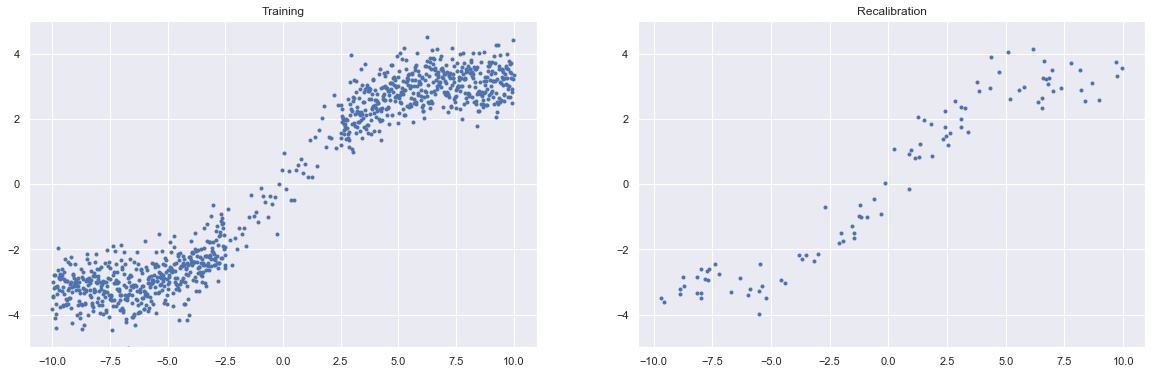

In [2]:
n = 1000
ns = [int(0.475*n), int(0.05*n), int(0.475*n)]
x = np.concatenate([np.linspace(-10,-2.5,ns[0]), np.linspace(-2.5,2.5,ns[1]), np.linspace(2.5,10,ns[2])])
y = 0.4*x + np.sin(0.4*x) + np.random.normal(scale=0.5,size=n)

# evaluation dataset
n_eval = 100
x_eval = np.sort(10-20*np.random.rand(n_eval))
y_eval = 0.4*x_eval + np.sin(0.4*x_eval) + np.random.normal(scale=0.5,size=n_eval)

# plotting x and y
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax[0].plot(x, y, 'o', markersize=3)
ax[0].set_title('Training')
ax[0].set_ylim([-5,5])
ax[1].plot(x_eval, y_eval, 'o', markersize=3)
ax[1].set_title('Recalibration')
ax[1].set_ylim([-5,5]);

In [3]:
# bootstrap when doing CDF
n_boots = 1000

boot_preds = np.zeros(shape=(n_boots, len(x_eval)))

for i in range(n_boots):
    x_ = np.sort(10-20*np.random.rand(n_eval))
    y_ = 0.4*x_eval + np.sin(0.4*x_eval) + np.random.normal(scale=0.5,size=n_eval)
    
    # instantiate model and feature preprocessing objects
    model = LinearRegression()
    poly = PolynomialFeatures(10)
    # preprocess data
    x_ = poly.fit_transform(x_.reshape(-1,1))
    # fit
    model.fit(x_, y_)
    # preprocess features to evaluate
    x_eval_ = poly.transform(x_eval.reshape(-1,1))
    # predict
    preds = model.predict(x_eval_)
    # store bootstrapped predictions
    boot_preds[i,:] = preds

(1000, 11) (1000,)
74.0% of the points in the 90% PI


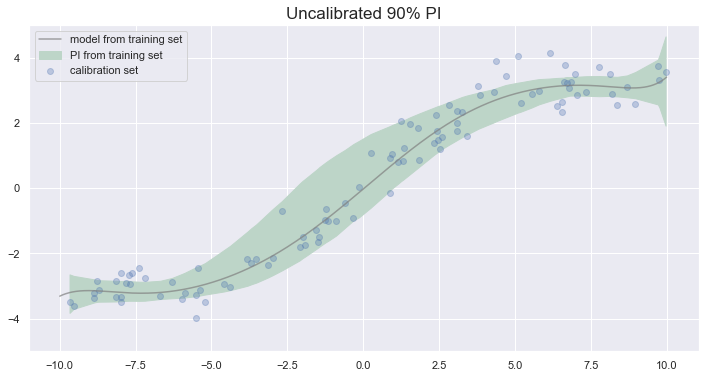

In [4]:
# point estimate
model = LinearRegression()
x_poly = poly.transform(x.reshape(-1,1))
model.fit(x_poly, y)
y_preds = model.predict(x_poly)
print(x_poly.shape, y_preds.shape)

# PI
lower_pi = np.percentile(boot_preds, 5, axis=0)
upper_pi = np.percentile(boot_preds, 95, axis=0)

perc_within = np.mean((y_eval <= upper_pi)*(y_eval >= lower_pi))
print(f'{perc_within*100:.1f}% of the points in the 90% PI')

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.fill_between(x_eval, y1=lower_pi, y2=upper_pi, color='#BDD5C8', label='PI from training set')
ax.scatter(x_eval, y_eval, alpha=0.3, label='calibration set')
ax.plot(x, y_preds, color='grey', alpha=0.7, label='model from training set')
ax.legend(loc='upper left')
ax.set_ylim([-5,5])
ax.set_title('Uncalibrated 90% PI', fontsize=17);

In [5]:
# calibrate this now
x_eval_ = poly.fit_transform(x_eval.reshape(-1,1))
h_xt_yt = np.mean(boot_preds <= model.predict(x_eval_), axis=0)

P_hat = np.zeros(len(h_xt_yt))
for i, p in enumerate(h_xt_yt):
    P_hat[i] = np.sum(h_xt_yt <= p)/len(h_xt_yt)
    
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(h_xt_yt, P_hat)

results = pd.DataFrame({'X':x_eval, 'y':y_eval, 'h_xt_yt':h_xt_yt, 'P_hat':P_hat})
results = results[['X','y','h_xt_yt','P_hat']]
results.head()

,X,y,h_xt_yt,P_hat
0,-9.678051,-3.499505,0.440,0.62
1,-9.542787,-3.601192,0.456,0.65
2,-8.867727,-3.353157,0.476,0.70
3,-8.859681,-3.216591,0.476,0.70
4,-8.764881,-2.832490,0.466,0.66


(100,) (100,)
0.44 0.313


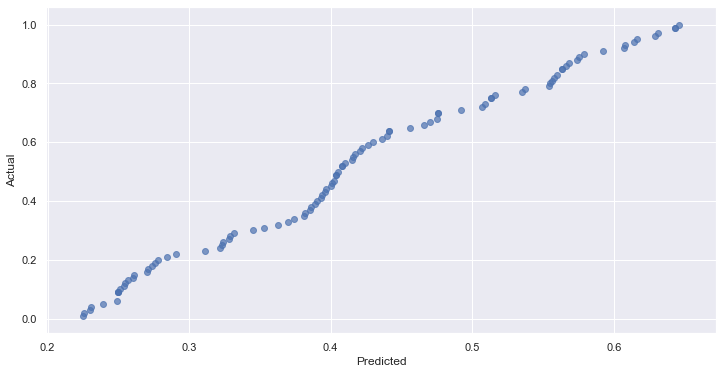

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(h_xt_yt, P_hat, alpha=0.7)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

# test set
x_test = np.sort(10-20*np.random.rand(n_eval))
y_test = 0.4*x_eval + np.sin(0.4*x_eval) + np.random.normal(scale=0.5,size=n_eval)

x_poly_test = poly.transform(x_test.reshape(-1,1))
h_xte_yte = np.mean(boot_preds <= model.predict(x_poly_test), axis=0)
print(h_xt_yt.shape, h_xte_yte.shape) # should be the same
print(h_xt_yt[0], h_xte_yte[0]) # should be different

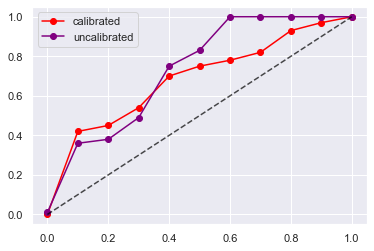

In [7]:
predicted_values = h_xte_yte
expected_values = np.linspace(0, 1, num=11).reshape(-1, 1)
calibrated_values = calibrator.predict(predicted_values)

observed_uncalibrated = np.mean(predicted_values.reshape(1, -1) <= expected_values, axis=1) 
observed_calibrated = np.mean(calibrated_values.reshape(1, -1) <= expected_values, axis=1) 

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(expected_values, observed_calibrated, 'o-', color='red', label='calibrated')
ax.plot(expected_values, observed_uncalibrated, 'o-', color='purple', label='uncalibrated')
ax.plot([0,1],[0,1], '--', color='black', alpha=0.7)
ax.legend();

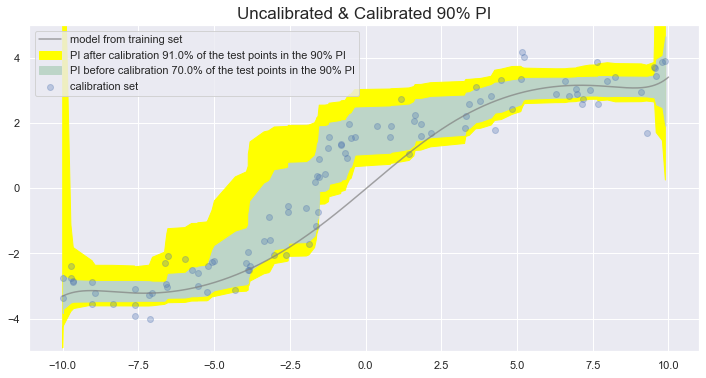

In [8]:
new_quantiles = calibrator.transform([0.05, 0.95])
    
# PI
lower_pi_cal = np.percentile(boot_preds, 100*new_quantiles[0], axis=0)
upper_pi_cal = np.percentile(boot_preds, 100*new_quantiles[1], axis=0)

perc_within_before = np.mean((y_test <= upper_pi)*(y_test >= lower_pi))
before = f'{perc_within_before*100:.1f}% of the test points in the 90% PI'

perc_within_after = np.mean((y_test <= upper_pi_cal)*(y_test >= lower_pi_cal))
after = f'{perc_within_after*100:.1f}% of the test points in the 90% PI'

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_ylim([-5,5])
ax.fill_between(x_test, y1=lower_pi_cal, y2=upper_pi_cal, color='yellow', label=f'PI after calibration {after}')
ax.fill_between(x_test, y1=lower_pi, y2=upper_pi, color='#BDD5C8', label=f'PI before calibration {before}')
ax.scatter(x_test, y_test, alpha=0.3, label='calibration set')
ax.plot(x, y_preds, color='grey', alpha=0.7, label='model from training set')
ax.legend(loc='upper left')
ax.set_title('Uncalibrated & Calibrated 90% PI', fontsize=17);

---